In [2]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calculate_precision, calculate_recall
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [3]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 37s, sys: 10.8 s, total: 1min 48s
Wall time: 1min 48s


## Feature selection

In [11]:
%%time

import xgboost as xgb
from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0.5
variables = ['data_t_air', 'data_t_road']

df_train = create_feature_df(train_clean[train_clean['date_time_utc'] < point], winter_period=False, 
                             time=time, variables=variables)
df_valid = create_feature_df(train_clean[train_clean['date_time_utc'] >= point], winter_period=False, 
                             time=time, variables=variables)
df_test = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_train if col.startswith('data_')]
features = [col for col in features if ('data_t_road' not in col)]
target = [col for col in df_train if col.startswith('target_')][0]

X_train = np.array(df_train[features].values)
y_train = np.array(df_train[target].values.reshape(-1, 1))

X_valid = np.array(df_valid[features].values)
y_valid = np.array(df_valid[target].values.reshape(-1, 1))

X_test = np.array(df_test[features].values)
y_test = np.array(df_test[target].values.reshape(-1, 1))

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_valid, y_valid)
dtest = xgb.DMatrix(X_test, y_test)

CPU times: user 5.64 s, sys: 1.48 s, total: 7.13 s
Wall time: 7.13 s


In [13]:
#from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from functools import partial

params = {}

params["eval_metric"] = 'mae'
params["eta"] = 0.1
params["lambda"] = 1. # 2 -- for noisy
#params["alpha"] = 1.0
params["subsample"] = 0.9 #
#params["min_child_weight"] = 1.
params["colsample_bytree"] = 0.9
params["max_depth"] = 7 # 4 -- for noisy
params["silent"] = 1
params["gamma"] = 0.1
delta = 1.
watchlist = [(dtrain, 'train'), (dval, 'valid')]

clf = xgb.train(params, dtrain, 200, watchlist, verbose_eval=20)

[0]	train-mae:11.6214	valid-mae:11.8577
[20]	train-mae:2.25749	valid-mae:2.44765
[40]	train-mae:1.79815	valid-mae:1.8912
[60]	train-mae:1.75871	valid-mae:1.86608
[80]	train-mae:1.74553	valid-mae:1.86317
[100]	train-mae:1.73516	valid-mae:1.86365
[120]	train-mae:1.72473	valid-mae:1.86407
[140]	train-mae:1.71563	valid-mae:1.86863
[160]	train-mae:1.70743	valid-mae:1.87168
[180]	train-mae:1.70098	valid-mae:1.87411
[199]	train-mae:1.69514	valid-mae:1.87463


import pickle

pickle.dump(clf, open('/mnt/HARD/MinMax94/models/pickle/xgboost_air.pickle', "wb"))

In [14]:
from sklearn.metrics import mean_absolute_error

y_true = dtest.get_label()
y_pred = clf.predict(dtest).ravel()

import pickle

clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/xgboost.pickle', 'rb'))

In [24]:
import numpy as np
import pickle
#clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/xgboost.pickle', "rb"))
std = np.std(y_true - y_pred)
print(mean_absolute_error(y_true, y_pred))
upper = y_pred + std * 4
lower = y_pred - std * 4
df_test['label_predict'] = ((y_true >= upper) | (y_true <= lower))
df_test['decision_function'] = np.abs(y_true - y_pred)

2.0441895


In [29]:
df_test.to_csv('/mnt/HARD/MinMax94/models/results/xgboost_air_4.csv', index=False)

## Recall

In [25]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')

st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    predicted_anomalies = df[df['label_predict']==1]
    for anomaly in predicted_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        predicted_anomalies_ids.update(set(locality.index))

true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
recall = len(tp) / len(true_anomalies_ids)
recall

0.6975308641975309

## Precision

In [26]:
true_anomalies_ids = set()
window = pd.Timedelta('4h')

#st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
for station in st_id:
    df = df_test[df_test['station_id']==station]
    true_anomalies = df[df['label_true']==1]
    for anomaly in true_anomalies.iterrows():
        dt = anomaly[1]['date_time_utc']
        locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                       (df_test['date_time_utc'] <= (dt + window))]
        
        true_anomalies_ids.update(set(locality.index))
        # print(list(locality.index))

predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
precision = len(tp) / len(predicted_anomalies_ids)
precision

0.614

## Cycle

In [17]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')
station_list = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

for station_id in station_list:
    st_id = [station_id]
    for station in st_id:
        df = df_test[df_test['station_id']==station]
        predicted_anomalies = df[df['label_predict']==1]
        for anomaly in predicted_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            predicted_anomalies_ids.update(set(locality.index))

    true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    recall = len(tp) / len(true_anomalies_ids)

    true_anomalies_ids = set()
    window = pd.Timedelta('4h')

    for station in st_id:
        df = df_test[df_test['station_id']==station]
        true_anomalies = df[df['label_true']==1]
        for anomaly in true_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            true_anomalies_ids.update(set(locality.index))
            # print(list(locality.index))

    predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    precision = len(tp) / len(predicted_anomalies_ids)
    
    print('{0} : R = {1:0.3f}, P = {2:0.3f}'.format(station_id, recall, precision))

114 : R = 0.611, P = 0.240
117 : R = 0.543, P = 0.970
119 : R = 0.848, P = 0.724
302 : R = 0.567, P = 0.414
303 : R = 0.730, P = 0.613
307 : R = 0.160, P = 0.950
393 : R = 0.099, P = 0.778
442 : R = 1.000, P = 0.458
503 : R = 0.861, P = 0.988
504 : R = 1.000, P = 0.696
511 : R = 1.000, P = 0.848
516 : R = 0.256, P = 0.769
1838 : R = 0.871, P = 0.167
1896 : R = 0.561, P = 0.809


## Plot

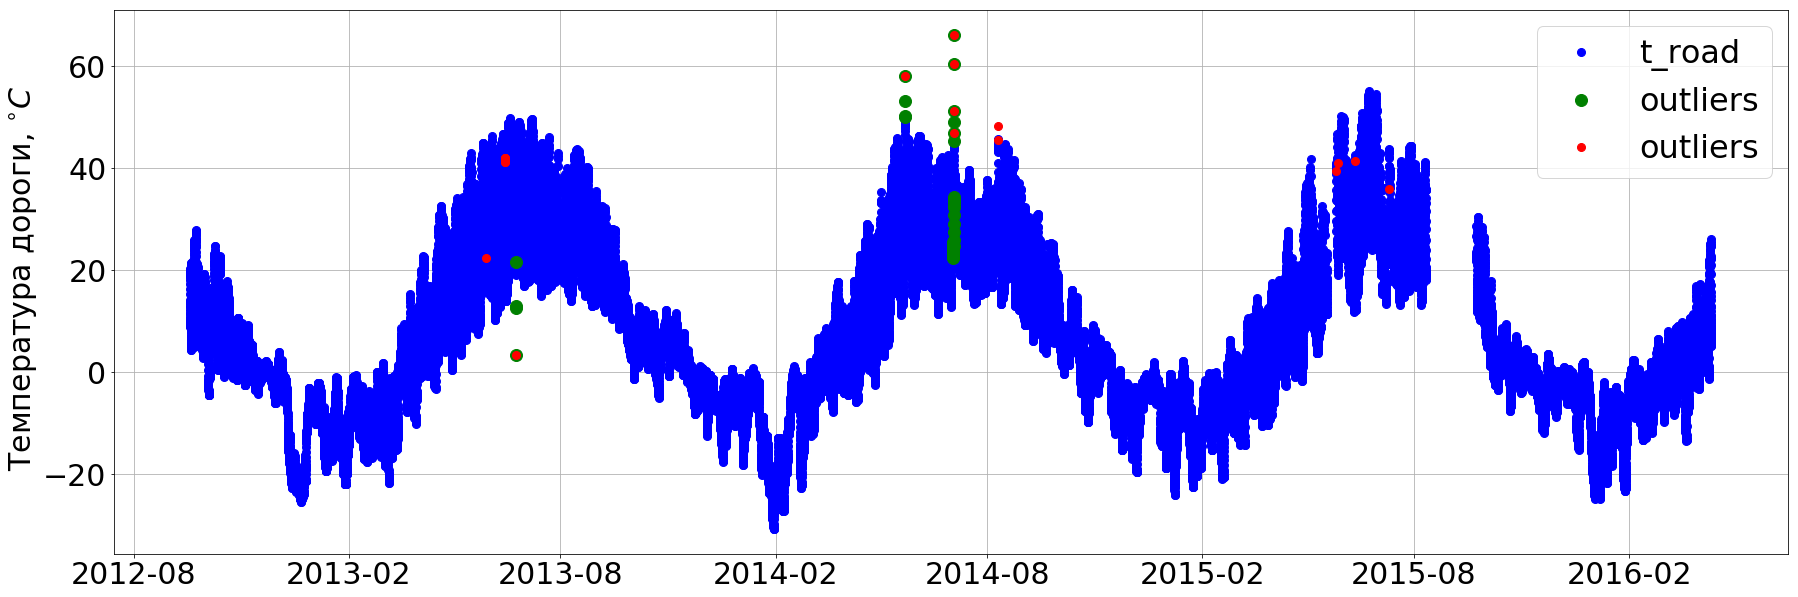

In [28]:
import matplotlib.pyplot as plt

#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 6, 1)
end = pd.Timestamp(2017, 8, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

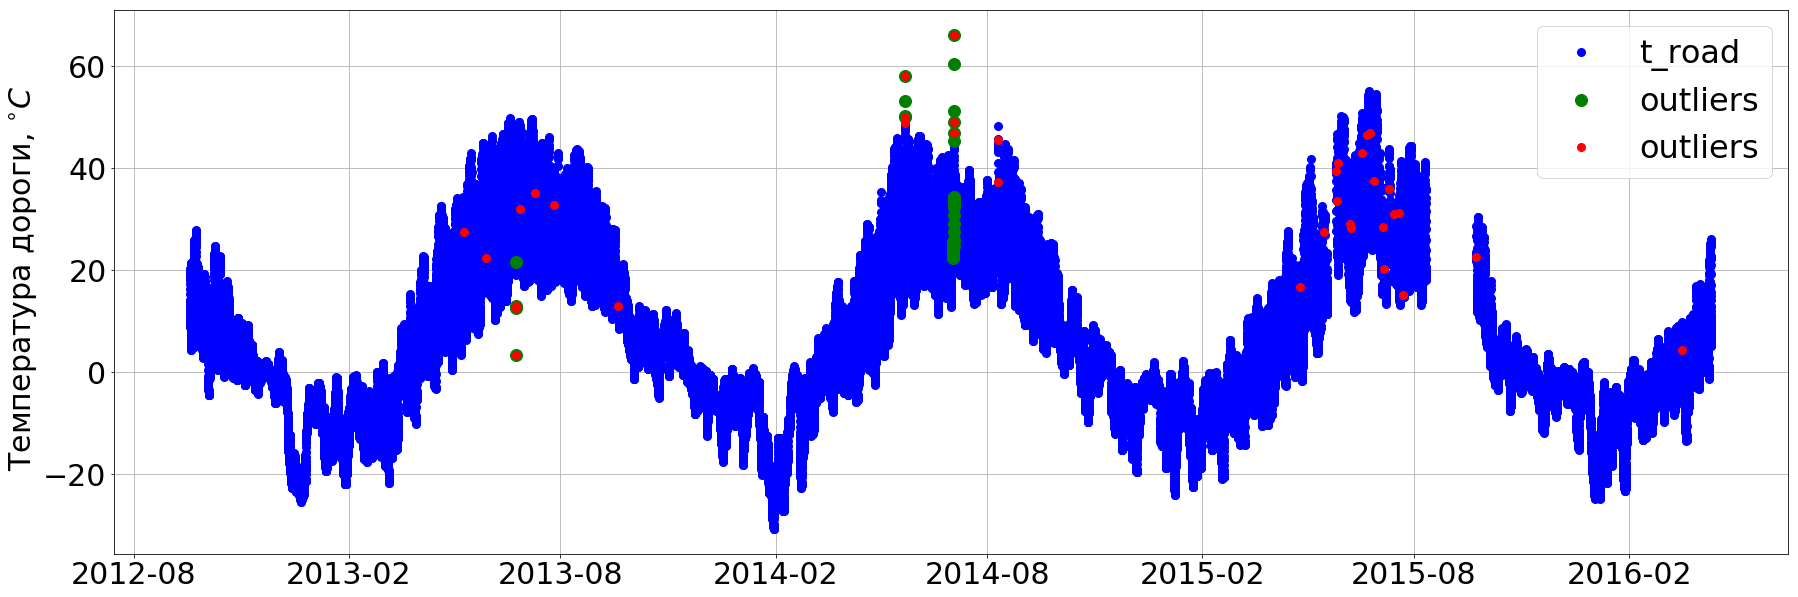

In [39]:
import matplotlib.pyplot as plt

#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 6, 1)
end = pd.Timestamp(2017, 8, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()